In [47]:
import fastf1 as ff1
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Global Variables
regulationYear = 2022
currentYear = datetime.now().year
gpEvent = 'R'
teamMapping = {
    'alphatauri': 'RB',
    'Alphatauri': 'RB', 
    'alfa romeo': 'Kick Sauber',
    'Alfa Romeo': 'Kick Sauber'
    # Add more team name changes here 'old name' : 'New Name'
}


In [48]:
def validateTrack(grandPrix):
    """
    Validate that the given Grand Prix name matches an official track name in FastF1.
    """
    yearToCheck = regulationYear  # Use the regulation year for track validation
    try:
        ff1.get_session(yearToCheck, grandPrix, gpEvent)  # Try loading the session
        return True
    except Exception:
        print(f"Error: '{grandPrix}' does not match an official track name in FastF1.")
        return False

In [49]:
def standardizeTeamName(teamName):
    """
    Standardize a team name using the teamMapping dictionary.
    """
    cleanedName = teamName.strip().title()
    return teamMapping.get(cleanedName, cleanedName)


In [50]:
def raceAnalysis(grandPrix):
    """
    Analyze driver and team performance at a given Grand Prix across years.
    """
    if not validateTrack(grandPrix):
        return None

    # Get all the years within the regulation window
    yearList = list(range(regulationYear, currentYear + 1))

    # Dictionary to store driver points data
    driverPointsData = {}

    # Dictionary to store team points data
    teamPointsData = {}

    for year in yearList:
        try:
            # Load race session for the given year and grand prix
            race = ff1.get_session(year, grandPrix, gpEvent)
            race.load()

            # Iterate through the session results DataFrame
            for _, row in race.results.iterrows():
                driverAbbr = row['Abbreviation']  # Driver abbreviation
                points = row['Points']  # Points scored in the race
                teamName = row['TeamName']  # Team name
                
                # Standardize team name
                standardizedTeamName = standardizeTeamName(teamName)

                # Add points to driver data
                if driverAbbr not in driverPointsData:
                    driverPointsData[driverAbbr] = {}
                driverPointsData[driverAbbr][year] = points

                # Add points to team data
                if standardizedTeamName not in teamPointsData:
                    teamPointsData[standardizedTeamName] = {}
                teamPointsData[standardizedTeamName][year] = teamPointsData[standardizedTeamName].get(year, 0) + points

        except Exception as e:
            print(f"Could not load data for {grandPrix} in {year}: {e}")

    # Create DataFrames for driver and team points
    driverPointsDf = pd.DataFrame.from_dict(driverPointsData, orient='index')
    teamPointsDf = pd.DataFrame.from_dict(teamPointsData, orient='index')

    # Replace NaN with -99 for non-participation, but exclude from sum
    totalDriverPoints = driverPointsDf.sum(axis=1, skipna=True)  # Exclude NaN in sum
    totalTeamPoints = teamPointsDf.sum(axis=1, skipna=True)

    driverPointsDf = driverPointsDf.fillna(-99)
    teamPointsDf = teamPointsDf.fillna(-99)

    driverPointsDf['Total Points'] = totalDriverPoints
    teamPointsDf['Total Points'] = totalTeamPoints
    
    # Apply team name mapping to the index of the team points DataFrame
    teamPointsDf.index = teamPointsDf.index.to_series().apply(standardizeTeamName)

    # Sort both DataFrames by total points
    driverPointsDf = driverPointsDf.sort_values(by='Total Points', ascending=False)
    teamPointsDf = teamPointsDf.sort_values(by='Total Points', ascending=False)

    return driverPointsDf, teamPointsDf

In [51]:
def visualizeTrends(dataFrame, title, xlabel='Year', ylabel='Points', hue='Driver/Team'):
    """
    Create a visualization of trends over the years using Seaborn.
    """
    # Prepare the data for visualization
    dataFrame = dataFrame.drop(columns=['Total Points'])  # Drop before melting
    meltedDf = dataFrame.reset_index().melt(
        id_vars='index', 
        var_name='Year', 
        value_name='Points'
    )
    
    # Ensure numeric data types
    meltedDf['Year'] = pd.to_numeric(meltedDf['Year'], errors='coerce')
    meltedDf['Points'] = pd.to_numeric(meltedDf['Points'], errors='coerce')

    # Exclude invalid rows
    meltedDf = meltedDf[meltedDf['Points'] != -99]

    # Rename columns for clarity
    meltedDf.rename(columns={'index': hue}, inplace=True)

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=meltedDf, 
        x='Year', 
        y='Points', 
        hue=hue, 
        marker='o'
    )
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(ticks=meltedDf['Year'].unique(), labels=meltedDf['Year'].unique().astype(int))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=hue)
    plt.show()


core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']
core           INFO 	Loading data for Italian Grand Prix - Race

Driver DataFrame:
     2022  2023  2024  Total Points
VER  25.0  25.0   8.0          58.0
LEC  18.0  12.0  25.0          55.0
SAI  12.0  15.0  12.0          39.0
RUS  15.0  10.0   6.0          31.0
PER   9.0  18.0   4.0          31.0
HAM  10.0   8.0  10.0          28.0
NOR   6.0   4.0  16.0          26.0
PIA -99.0   0.0  18.0          18.0
ALB -99.0   6.0   2.0           8.0
GAS   4.0   0.0   0.0           4.0
ALO   0.0   2.0   0.0           2.0
DEV   2.0 -99.0 -99.0           2.0
BOT   0.0   1.0   0.0           1.0
MAG   0.0   0.0   1.0           1.0
ZHO   1.0   0.0   0.0           1.0
SAR -99.0   0.0 -99.0           0.0
HUL -99.0   0.0   0.0           0.0
VET   0.0 -99.0 -99.0           0.0
LAW -99.0   0.0 -99.0           0.0
TSU   0.0   0.0   0.0           0.0
STR   0.0   0.0   0.0           0.0
RIC   0.0 -99.0   0.0           0.0
LAT   0.0 -99.0 -99.0           0.0
MSC   0.0 -99.0 -99.0           0.0
OCO   0.0   0.0   0.0           0.0
COL -99.0 -99.0   0.0           0.0

Team Data

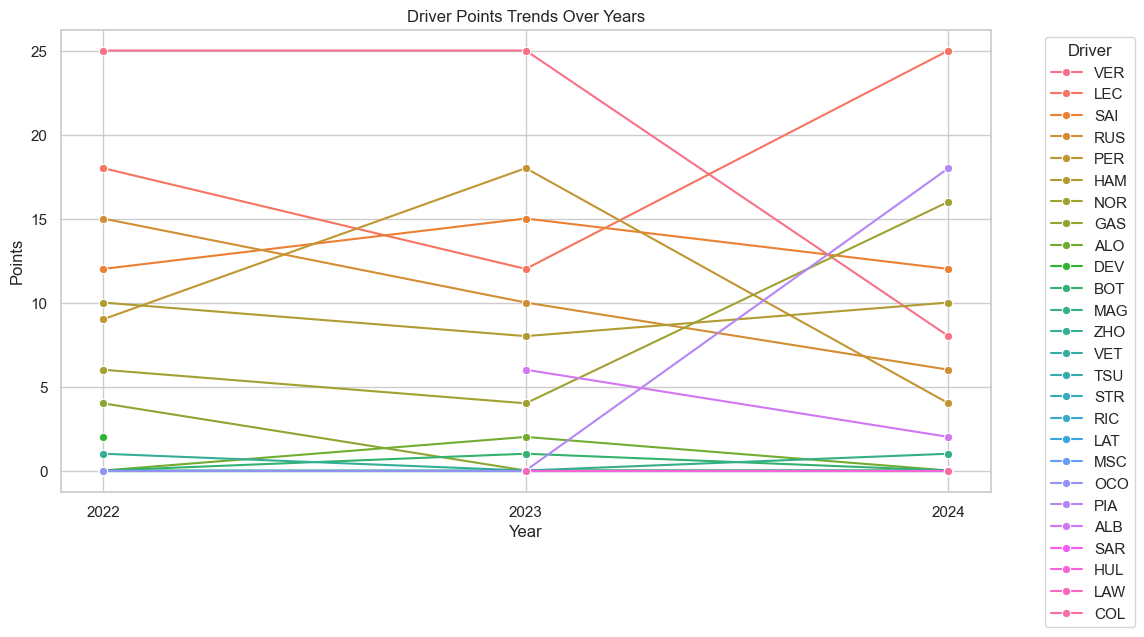

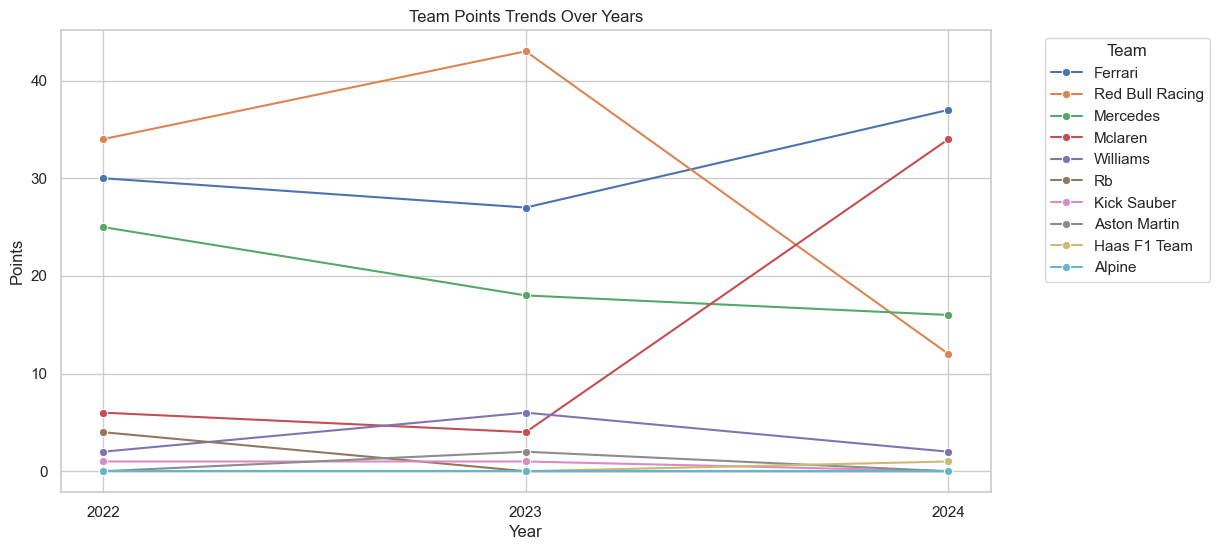

In [52]:
# Example usage
grandPrix = "Monza"  # Replace with the desired Grand Prix name
driverDf, teamDf = raceAnalysis(grandPrix)

if driverDf is not None and teamDf is not None:
    print("Driver DataFrame:")
    print(driverDf)
    print("\nTeam DataFrame:")
    print(teamDf)

    # Visualize driver trends
    visualizeTrends(driverDf, title="Driver Points Trends Over Years", hue="Driver")

    # Visualize team trends
    visualizeTrends(teamDf, title="Team Points Trends Over Years", hue="Team")